# <center><font color=	DarkRed>Partie 2 : Détectez les Bad Buzz grâce au Deep Learning - Modèle simple</font></center><br>

Dans cette partie, Je vais tester l'approche **“Modèle sur mesure simple”**, afin de développer rapidement un modèle classique (ex : régression logistique) permettant de prédire le sentiment associé à un tweet.

## Importation des librairies

In [ ]:
import numpy as np 
import pandas as pd
import time

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import classification_report, confusion_matrix
from sklearn import metrics
from sklearn.metrics import (f1_score, 
                             fbeta_score, 
                             recall_score, 
                             precision_score, 
                             accuracy_score, 
                             roc_auc_score, 
                             confusion_matrix, 
                             classification_report, 
                             ConfusionMatrixDisplay,
                             PrecisionRecallDisplay,
                             RocCurveDisplay)


# Classification libraries
import pickle
from sklearn.metrics import f1_score, recall_score, precision_score
from sklearn.naive_bayes import BernoulliNB
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression

# Graph libraries to produce graphs 
import matplotlib.pyplot as plt 
import seaborn as sns 
import plotly.express as px

pd.options.mode.chained_assignment = None

# Pour la gestion des alertes
import warnings 
from warnings import simplefilter
warnings.simplefilter(action="ignore", category=FutureWarning)
warnings.simplefilter(action="ignore", category=pd.errors.PerformanceWarning)
warnings.simplefilter(action="ignore", category=RuntimeWarning)
warnings.simplefilter(action="ignore", category=DeprecationWarning);

import os
import json

compare_scores = {}
train_times = {}

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Declaration des fonctions

In [ ]:
def model_Evaluate(cm, title, pred):
    # Prédire les valeurs pour l'ensemble de données de test
    # y_pred = model.predict(X_test)
    # Imprimez les métriques d'évaluation pour l'ensemble de données.
    print(classification_report(y_test, pred))
    # Calculer et tracer la matrice de confusion
    # cf_matrix = confusion_matrix(y_test, y_pred)
    categories = ['Negative','Positive']
    group_names = ['Vrais Neg','Faux Pos', 'Faux Neg','Vrais Pos']
    group_percentages = ['{0:.2%}'.format(value) for value in cm.flatten() / np.sum(cm)]
    labels = [f'{v1}n{v2}' for v1, v2 in zip(group_names,group_percentages)]
    labels = np.asarray(labels).reshape(2,2)
    sns.heatmap(cm, annot = labels, cmap = 'Blues',fmt = '',
    xticklabels = categories, yticklabels = categories)
    plt.xlabel("Valeurs prédites", fontdict = {'size':14}, labelpad = 10)
    plt.ylabel("Valeurs réelles" , fontdict = {'size':14}, labelpad = 10)
    plt.title (title, fontdict = {'size':18}, pad = 20)

def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()
'''
from datetime import datetime
log_dir="logs/fit/" + datetime.now().strftime("%Y%m%d-%H%M%S")  
callbacks = [
    tf.keras.callbacks.EarlyStopping(patience=3),
    tf.keras.callbacks.ModelCheckpoint(filepath='model.{epoch:02d}-{val_loss:.2f}.h5'), 
    tf.keras.callbacks.TensorBoard(log_dir),
]
'''

def compare_scoring(y_true, y_pred, training_time, predict_time):
    return {
            "f1 score": metrics.f1_score(y_true, y_pred),
            "fbeta score": metrics.fbeta_score(y_true, y_pred, beta=0.5),
            "accuracy": metrics.accuracy_score(y_true, y_pred),
            "recall": metrics.recall_score(y_true, y_pred),
            "AUC": metrics.roc_auc_score(y_true, y_pred),
            "Training time": training_time,
            "Predict time": predict_time
        }

## <center><font color=darkRed>1 - Chargement des données</font></center>

In [ ]:
data = pd.read_csv('../content/drive/MyDrive/projet-7/data/final_df.csv', sep=',')
data.head()

,sentiment,id,flag,user,tweet,sentiment_string,word_count,lem_tweet,lem_SW_tweet,stem_tweet
0,0,2200003196,NO_QUERY,LaLaLindsey0609,@chrishasboobs AHHH I HOPE YOUR OK!!!,NEGATIF,6,user ahhh i hope your ok,user ahhh hope ok,user ahhh i hope your ok
1,0,1467998485,NO_QUERY,sexygrneyes,"@misstoriblack cool , i have no tweet apps fo...",NEGATIF,12,user cool i have no tweet apps for my razr,user cool tweet apps razr,user cool i have no tweet app for my razr
2,0,2300048954,NO_QUERY,sammydearr,@TiannaChaos i know just family drama. its la...,NEGATIF,27,user i know just family drama it lamehey next ...,user know family drama lamehey next time u han...,user i know just famili drama it lamehey next ...
3,0,1993474027,NO_QUERY,Lamb_Leanne,School email won't open and I have geography ...,NEGATIF,16,school email wont open and i have geography st...,school email wont open geography stuff revise ...,school email will not open and i have geograph...
4,0,2256550904,NO_QUERY,yogicerdito,upper airways problem,NEGATIF,3,upper airway problem,upper airway problem,upper airway problem


In [ ]:
X=data.lem_tweet
y=data.sentiment

## <center><font color=darkRed>2 - Modèle sur mesure simple</font></center>

je vais utilisé respectivement trois modèles de classification linéaire différents :

- Bernoulli Naïf Bayes *(modèle bayésien naïf )*
- SVM *(machine à vecteur de support)*
- Régression logistique

L'idée derrière le choix de ces modèles est de trouver celui qui donne les meilleures performances de classifications.

### <center><font color=darkBlue>2.1 - Train, Test, split</font></center>

In [ ]:
# Separating the 95% data for training data and 5% for testing data
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size = 0.3, random_state =42)
print("TRAIN size:", X_train.shape)
print("TEST size:", X_test.shape)

TRAIN size: (1116321,)
TEST size: (478424,)


### <center><font color=darkBlue>2.2 - Vectorisation TF-IDF</font></center>

In [ ]:
vectoriser = TfidfVectorizer(ngram_range=(1,2), max_features=500000)
vectoriser.fit(X_train.apply(lambda x: np.str_(x)))
print('Nombres de mots: ', len(vectoriser.get_feature_names()))

Nombres de mots:  500000


In [ ]:
X_train = vectoriser.transform(X_train.apply(lambda x: np.str_(x)))
X_test  = vectoriser.transform(X_test.apply(lambda x: np.str_(x)))

### <center><font color=darkBlue>2.3 - Modèle Bernoulli</font></center>

Le modèle **BernoulliNB est un modèle de classificateurs bayésiens**.
**Naïve Bayes**.
Il est surtout utilisées en classification de données textuelles.
**Le classificateur BernoulliNB** compte le nombre de fois où
les variables sont différentes de zéro sur chaque classe, il est utilisé pour les données discrètes.

La principale caractéristique de Bernoulli Naive Bayes est qu'il n'accepte les caractéristiques que sous forme de valeurs binaires telles que vrai ou faux, oui ou non, succès ou échec, 0 ou 1, etc. 

#### <center><font color=darkGreen>2.3.1 - Entrainement du modèle</font></center>

In [ ]:
model_name = 'BernoulliNB'
BNBmodel = BernoulliNB()
start_train = time.time()
BNBmodel.fit(X_train, y_train)
end_train = time.time()
training_time = end_train - start_train


#### <center><font color=darkGreen>2.3.1 - Performance du modèle</font></center>

              precision    recall  f1-score   support

           0       0.80      0.79      0.80    239046
           1       0.79      0.81      0.80    239378

    accuracy                           0.80    478424
   macro avg       0.80      0.80      0.80    478424
weighted avg       0.80      0.80      0.80    478424



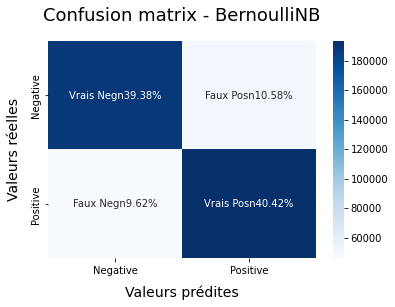

In [ ]:
#model_Evaluate(BNBmodel)
# Create confusion matrix, classification report
start_pred = time.time()
y_pred_BNB = BNBmodel.predict(X_test)
end_pred = time.time()
predict_time = end_pred - start_pred

cm = confusion_matrix(y_test, y_pred_BNB)
title = 'Confusion matrix - BernoulliNB'
model_Evaluate(cm, title, y_pred_BNB)

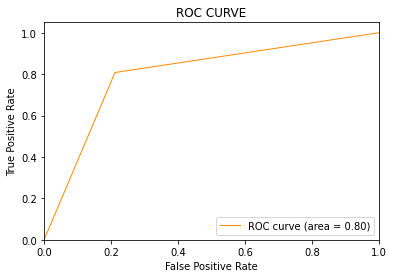

In [ ]:
from sklearn.metrics import roc_curve, auc
fpr, tpr, thresholds = roc_curve(y_test, y_pred_BNB)
roc_auc = auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=1, label='ROC curve (area = %0.2f)' % roc_auc)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC CURVE')
plt.legend(loc="lower right")
plt.show()

In [ ]:
compare_scores[model_name] = compare_scoring(y_test, y_pred_BNB, training_time, predict_time)
#compare_model = pd.DataFrame.from_dict(compare_scores, orient='index')
#compare_model

### <center><font color=darkBlue>2.4 - Modèle SVC</font></center>

**SVC** ***(Support Vector Classifier)*** est un algorithme de machine learning faisant parti de la famille des SVM (Support Vector Machine) 

**Le SVM** appartient à la catégorie des **classificateurs linéaire** (qui utilisent une séparation linéaire des données), et qui dispose de sa méthode à lui pour trouver la frontière entre les catégories.

l'un des avantages des SVM, est qu'ils sont très efficaces quand on ne dispose que de peu de données d’entraînement : alors que d’autres algorithmes n’arriveraient pas à généraliser correctement, on observe que les SVM sont beaucoup plus efficaces. Cependant, quand les données sont trop nombreuses, le SVM a tendance à baisser en performance.



#### <center><font color=darkGreen>2.4.1 - Entrainement du modèle</font></center>

In [ ]:
model_name = 'LinearSVC'
SVCmodel = LinearSVC()

start_train = time.time()
SVCmodel.fit(X_train, y_train)
end_train = time.time()
training_time = end_train - start_train

#### <center><font color=darkGreen>2.4.2 - Performance du modèle</font></center>

              precision    recall  f1-score   support

           0       0.82      0.80      0.81    239046
           1       0.81      0.82      0.81    239378

    accuracy                           0.81    478424
   macro avg       0.81      0.81      0.81    478424
weighted avg       0.81      0.81      0.81    478424



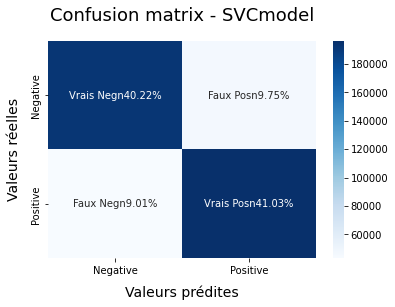

In [ ]:
#model_Evaluate(SVCmodel)
start_pred = time.time()
y_pred_svc = SVCmodel.predict(X_test)
end_pred = time.time()
predict_time = end_pred - start_pred

cm = confusion_matrix(y_test, y_pred_svc)
title = 'Confusion matrix - SVCmodel'
model_Evaluate(cm, title, y_pred_svc)

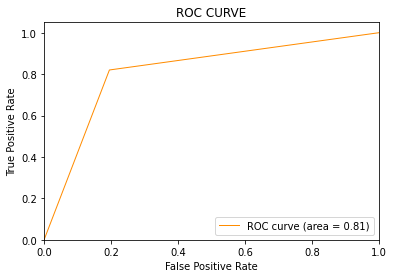

In [ ]:
from sklearn.metrics import roc_curve, auc
fpr, tpr, thresholds = roc_curve(y_test, y_pred_svc)
roc_auc = auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=1, label='ROC curve (area = %0.2f)' % roc_auc)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC CURVE')
plt.legend(loc="lower right")
plt.show()


In [ ]:
compare_scores[model_name] = compare_scoring(y_test, y_pred_svc, training_time, predict_time)
#compare_model = pd.DataFrame.from_dict(compare_scores, orient='index')
#compare_model

### <center><font color=darkBlue>2.5 - Modèle Regression logistique</font></center>

La **régression logistique** est une méthode de **classification linéaire** qui apprend la probabilité qu'un échantillon appartienne à une certaine classe.  

Ce type de modèle statistique (également appelé modèle logit) est souvent utilisé pour la classification et l'analyse prédictive. 

La régression logistique estime la probabilité qu'un événement se produise, tel que voter ou ne pas voter, sur la base d'un ensemble de données de variables indépendantes.

#### <center><font color=darkGreen>2.5.1 - Entrainement du modèle</font></center>

In [ ]:
model_name = 'LogisticRegression'
LRmodel = LogisticRegression(C = 2, max_iter = 1000, n_jobs=-1)

start_train = time.time()
LRmodel.fit(X_train, y_train)
end_train = time.time()
training_time = end_train - start_train

#### <center><font color=darkGreen>2.5.1 - Performance du modèle</font></center>

              precision    recall  f1-score   support

           0       0.83      0.81      0.82    239046
           1       0.82      0.83      0.82    239378

    accuracy                           0.82    478424
   macro avg       0.82      0.82      0.82    478424
weighted avg       0.82      0.82      0.82    478424



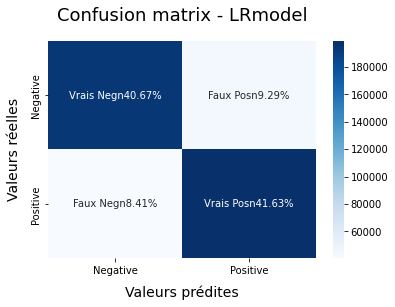

In [ ]:
start_pred = time.time()
y_pred_LR = LRmodel.predict(X_test)
end_pred = time.time()
predict_time = end_pred - start_pred

cm = confusion_matrix(y_test, y_pred_LR)
title = 'Confusion matrix - LRmodel'
model_Evaluate(cm, title, y_pred_LR)

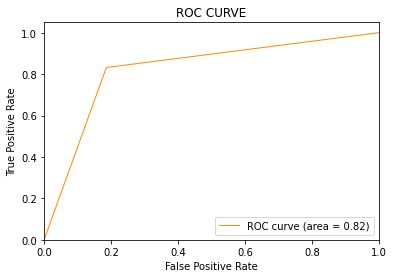

In [ ]:
from sklearn.metrics import roc_curve, auc
fpr, tpr, thresholds = roc_curve(y_test, y_pred_LR)
roc_auc = auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=1, label='ROC curve (area = %0.2f)' % roc_auc)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC CURVE')
plt.legend(loc="lower right")
plt.show()

In [ ]:
compare_scores[model_name] = compare_scoring(y_test, y_pred_LR, training_time, predict_time)
#compare_model = pd.DataFrame.from_dict(compare_scores, orient='index')
#compare_model

### <center><font color=darkBlue>2.6 - Comparaison des modèles</font></center>

In [ ]:
compare_model = pd.DataFrame.from_dict(compare_scores, orient='index')
compare_model

,f1 score,fbeta score,accuracy,recall,AUC,Training time,Predict time
BernoulliNB,0.800074,0.795518,0.798008,0.807785,0.798001,0.580399,0.209882
LinearSVC,0.813961,0.810375,0.812449,0.820009,0.812444,24.621607,0.050732
LogisticRegression,0.824657,0.820348,0.822985,0.831939,0.822979,184.211845,0.051044


### <center><font color=darkBlue>2.6 - Conclusion</font></center>

Après avoir évalué tous les modèles, je peux  conclure les détails suivants : 

|| BernoulliNB | SVC | LogisticRegression |
| --- | --- | --- | --- |
| F1-Score | 0.80 | 0.81 | **0.82** |
| FBeta-Score | 0.80 | 0.81 | **0.82** |
| Precision | 0.80 | 0.81| **0.82** |
| Recall | 0.81 | 0.82 | **0.83** |
| AUC | 0.80 | 0.81 | **0.82** |
| Temps d'entrainement | **0.6** | 25 | 201 |
| Temps de prediction | 0.22 | 0.0503 | **0.0500**|



- Le modèle BernoulliNB est celui ayant obtenus les moins bon resultats, il est le plus rapide en temps d'entrainement.

- Le modèle SVC fonctionne mieux que BernoulliNB il est plus rapide en temps de prediction 
 
- Le modèle LR est celui offrant de meilleurs résultats 

Je peux conclure que **la régression logistique** est le **meilleur modèle** pour l'ensemble de données ci-dessus.